Predictive Maintenance for Factory Machines 

Data cleaning & Time series preparation

loading the training data

In [2]:
import pandas as pd
import numpy as np

# Column names based on NASA documentation
columns = [
    "engine_id", "cycle",
    "op_setting_1", "op_setting_2", "op_setting_3"
] + [f"sensor_{i}" for i in range(1, 22)]

# Load train and test data
train = pd.read_csv("train_FD001.txt", sep=r"\s+", header=None)
test = pd.read_csv("test_FD001.txt", sep=r"\s+", header=None)

train.columns = columns
test.columns = columns

print(train.head())
print(train.shape)


   engine_id  cycle  op_setting_1  op_setting_2  op_setting_3  sensor_1  \
0          1      1       -0.0007       -0.0004         100.0    518.67   
1          1      2        0.0019       -0.0003         100.0    518.67   
2          1      3       -0.0043        0.0003         100.0    518.67   
3          1      4        0.0007        0.0000         100.0    518.67   
4          1      5       -0.0019       -0.0002         100.0    518.67   

   sensor_2  sensor_3  sensor_4  sensor_5  ...  sensor_12  sensor_13  \
0    641.82   1589.70   1400.60     14.62  ...     521.66    2388.02   
1    642.15   1591.82   1403.14     14.62  ...     522.28    2388.07   
2    642.35   1587.99   1404.20     14.62  ...     522.42    2388.03   
3    642.35   1582.79   1401.87     14.62  ...     522.86    2388.08   
4    642.37   1582.85   1406.22     14.62  ...     522.19    2388.04   

   sensor_14  sensor_15  sensor_16  sensor_17  sensor_18  sensor_19  \
0    8138.62     8.4195       0.03        392

In [3]:
print("Number of engines:", train["engine_id"].nunique())
print("Max cycles (sample):")
train.groupby("engine_id")["cycle"].max().head()

Number of engines: 100
Max cycles (sample):


engine_id
1    192
2    287
3    179
4    189
5    269
Name: cycle, dtype: int64

In [4]:
# Create explicit run identifier (engine run)
train["run_id"] = train["engine_id"]
test["run_id"] = test["engine_id"]


handling missing values

In [5]:
# Check for missing cycles per engine
def check_missing_cycles(df):
    for eid in df["engine_id"].unique():
        cycles = df[df["engine_id"] == eid]["cycle"].values
        if not np.array_equal(cycles, np.arange(1, cycles[-1] + 1)):
            return False
    return True

print("Train cycles OK:", check_missing_cycles(train))
print("Test cycles OK:", check_missing_cycles(test))

engine_id = 1
train[train.engine_id == engine_id][["engine_id", "cycle"]].head(10)


Train cycles OK: True
Test cycles OK: True


,engine_id,cycle
0,1,1
1,1,2
2,1,3
3,1,4
4,1,5
5,1,6
6,1,7
7,1,8
8,1,9
9,1,10


definins sensor columns and saving raw copy

In [6]:
sensor_cols = [c for c in train.columns if c.startswith("sensor")]
train_raw = train.copy()


Removing low variance sensors(standardization)

In [7]:
sensor_variance = train_raw[sensor_cols].var()
low_var_sensors = sensor_variance[sensor_variance < 0.01].index.tolist()

print("Low variance sensors removed:", low_var_sensors)

print("Remaining sensors:", len(sensor_cols))
sensor_variance.sort_values().head(10)

train.drop(columns=low_var_sensors, inplace=True)
test.drop(columns=low_var_sensors, inplace=True)

# Update sensor column list
sensor_cols = [c for c in train.columns if c.startswith("sensor")]

Low variance sensors removed: ['sensor_1', 'sensor_5', 'sensor_6', 'sensor_8', 'sensor_10', 'sensor_13', 'sensor_15', 'sensor_16', 'sensor_18', 'sensor_19']
Remaining sensors: 21


Normalizing sensor data

In [8]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()

train[sensor_cols] = scaler.fit_transform(train[sensor_cols])
test[sensor_cols] = scaler.transform(test[sensor_cols])

train[sensor_cols].describe().loc[["mean", "std"]].T.head()



,mean,std
sensor_2,6.410348e-14,1.000024
sensor_3,-1.249503e-14,1.000024
sensor_4,9.147407e-16,1.000024
sensor_7,-3.159162e-14,1.000024
sensor_9,-4.185214e-14,1.000024


visualizing sensor drift

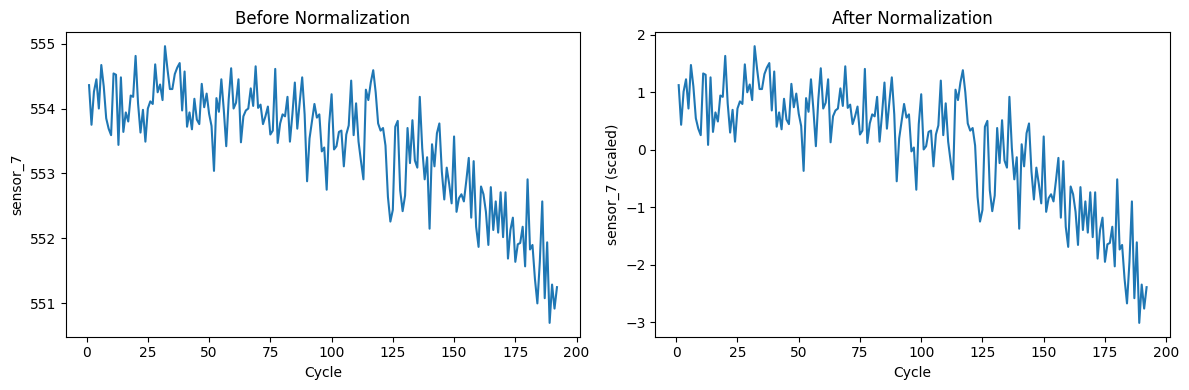

In [9]:
import matplotlib.pyplot as plt
engine_id = 1
sensor_to_plot = "sensor_7"

plt.figure(figsize=(12,4))

plt.subplot(1,2,1)
plt.plot(
    train_raw[train_raw.engine_id == engine_id]["cycle"],
    train_raw[train_raw.engine_id == engine_id][sensor_to_plot]
)
plt.title("Before Normalization")
plt.xlabel("Cycle")
plt.ylabel(sensor_to_plot)

plt.subplot(1,2,2)
plt.plot(
    train[train.engine_id == engine_id]["cycle"],
    train[train.engine_id == engine_id][sensor_to_plot]
)
plt.title("After Normalization")
plt.xlabel("Cycle")
plt.ylabel(sensor_to_plot + " (scaled)")

plt.tight_layout()
plt.show()


In [10]:
train.describe().T.head()

,count,mean,std,min,25%,50%,75%,max
engine_id,20631.0,51.506568,29.227633,1.0000,26.0000,52.0,77.0000,100.0000
cycle,20631.0,108.807862,68.880990,1.0000,52.0000,104.0,156.0000,362.0000
op_setting_1,20631.0,-0.000009,0.002187,-0.0087,-0.0015,0.0,0.0015,0.0087
op_setting_2,20631.0,0.000002,0.000293,-0.0006,-0.0002,0.0,0.0003,0.0006
op_setting_3,20631.0,100.000000,0.000000,100.0000,100.0000,100.0,100.0000,100.0000


Feature Engineering

defining sensor columns again to check if sensors were dropped in cleaning or not 

In [11]:
sensor_cols = [c for c in train.columns if c.startswith("sensor")]
print("Number of sensors:", len(sensor_cols))

Number of sensors: 11


Computing RUL for train data

for each engine : RUL = max_cycle_for_engine - current_cycle

In [12]:
# Get max cycle per engine
max_cycle = train.groupby("engine_id")["cycle"].max().reset_index()
max_cycle.columns = ["engine_id", "max_cycle"]

# Merge back
train = train.merge(max_cycle, on="engine_id", how="left")

# Compute RUL
train["RUL"] = train["max_cycle"] - train["cycle"]

train[["engine_id", "cycle", "RUL"]].head()


,engine_id,cycle,RUL
0,1,1,191
1,1,2,190
2,1,3,189
3,1,4,188
4,1,5,187


In [13]:
train.drop(columns=["max_cycle"], inplace=True)

Cycle based degradation features

normalizing cycle position per engine

In [14]:
train["cycle_norm"] = train.groupby("engine_id")["cycle"].transform(
    lambda x: x / x.max()
)

test["cycle_norm"] = test.groupby("engine_id")["cycle"].transform(
    lambda x: x / x.max()
)

train[train.engine_id == engine_id][["cycle", "cycle_norm"]].tail()


,cycle,cycle_norm
187,188,0.979167
188,189,0.984375
189,190,0.989583
190,191,0.994792
191,192,1.000000


Rolling window statistics

Rolling mean

In [15]:
window = 10

for sensor in sensor_cols:
    train[f"{sensor}_roll_mean"] = (
        train.groupby("engine_id")[sensor]
        .rolling(window, min_periods=1)
        .mean()
        .reset_index(level=0, drop=True)
    )

    test[f"{sensor}_roll_mean"] = (
        test.groupby("engine_id")[sensor]
        .rolling(window, min_periods=1)
        .mean()
        .reset_index(level=0, drop=True)
    )

    


Rolling SD

In [16]:
for sensor in sensor_cols:
    train[f"{sensor}_roll_std"] = (
        train.groupby("engine_id")[sensor]
        .rolling(window, min_periods=1)
        .std()
        .reset_index(level=0, drop=True)
    )

    test[f"{sensor}_roll_std"] = (
        test.groupby("engine_id")[sensor]
        .rolling(window, min_periods=1)
        .std()
        .reset_index(level=0, drop=True)
    )


sensor deltas - degradation is about change over time not abs value

<Figure size 600x400 with 0 Axes>

<Figure size 600x400 with 0 Axes>

<Figure size 600x400 with 0 Axes>

<Figure size 600x400 with 0 Axes>

<Figure size 600x400 with 0 Axes>

<Figure size 600x400 with 0 Axes>

<Figure size 600x400 with 0 Axes>

<Figure size 600x400 with 0 Axes>

<Figure size 600x400 with 0 Axes>

<Figure size 600x400 with 0 Axes>

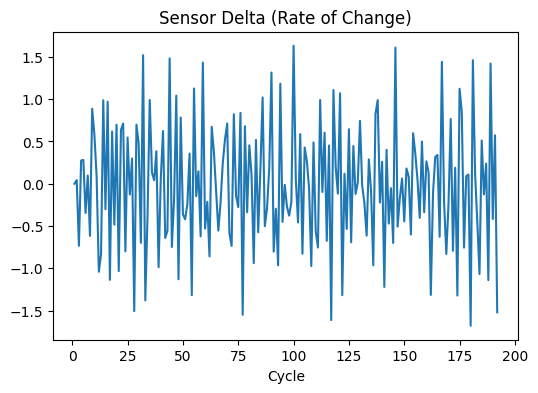

In [17]:
for sensor in sensor_cols:
    train[f"{sensor}_delta"] = (
        train.groupby("engine_id")[sensor].diff().fillna(0)
    )

    test[f"{sensor}_delta"] = (
        test.groupby("engine_id")[sensor].diff().fillna(0)
    )

    plt.figure(figsize=(6,4))
plt.plot(
    train[train.engine_id == engine_id]["cycle"],
    train[train.engine_id == engine_id][f"{sensor}_delta"]
)
plt.title("Sensor Delta (Rate of Change)")
plt.xlabel("Cycle")
plt.show()



degradation indicators

health index proxy

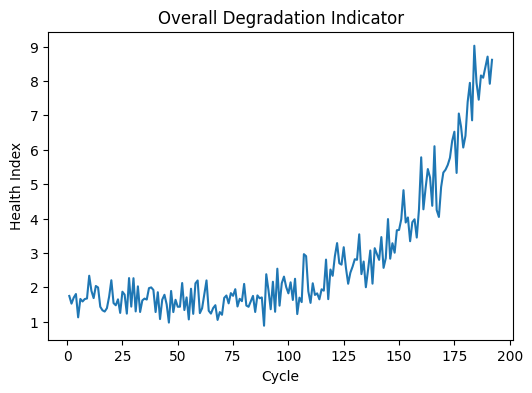

In [18]:
early_cycle_mean = train[train["cycle"] <= 5][sensor_cols].mean()

train["health_index"] = np.linalg.norm(
    train[sensor_cols] - early_cycle_mean, axis=1
)

test["health_index"] = np.linalg.norm(
    test[sensor_cols] - early_cycle_mean, axis=1
)
plt.figure(figsize=(6,4))
plt.plot(
    train[train.engine_id == engine_id]["cycle"],
    train[train.engine_id == engine_id]["health_index"]
)
plt.xlabel("Cycle")
plt.ylabel("Health Index")
plt.title("Overall Degradation Indicator")
plt.show()


Handle NaNs created by rolling

In [19]:
train.fillna(0, inplace=True)
test.fillna(0, inplace=True)

In [20]:
print("Train shape after feature engineering:", train.shape)
print("Test shape after feature engineering:", test.shape)

train.head()


Train shape after feature engineering: (20631, 53)
Test shape after feature engineering: (13096, 52)


,engine_id,cycle,op_setting_1,op_setting_2,op_setting_3,sensor_2,sensor_3,sensor_4,sensor_7,sensor_9,...,sensor_4_delta,sensor_7_delta,sensor_9_delta,sensor_11_delta,sensor_12_delta,sensor_14_delta,sensor_17_delta,sensor_20_delta,sensor_21_delta,health_index
0,1,1,-0.0007,-0.0004,100.0,-1.721725,-0.134255,-0.925936,1.121141,-0.862813,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.749541
1,1,2,0.0019,-0.0003,100.0,-1.061780,0.211528,-0.643726,0.431930,-0.958818,...,0.282210,-0.689210,-0.096004,0.074884,0.840637,-0.373774,0.000000,-0.331965,0.042495,1.526454
2,1,3,-0.0043,0.0003,100.0,-0.661813,-0.413166,-0.525953,1.008155,-0.557139,...,0.117773,0.576225,0.401678,-0.823720,0.189821,0.091215,-1.291384,-0.276637,-0.733499,1.700592
3,1,4,0.0007,0.0000,100.0,-0.661813,-1.261314,-0.784831,1.222827,-0.713826,...,-0.258878,0.214672,-0.156686,-0.524186,0.596581,0.031454,1.291384,-0.387292,0.274369,1.806401
4,1,5,-0.0019,-0.0002,100.0,-0.621816,-1.251528,-0.301518,0.714393,-0.457059,...,0.483313,-0.508434,0.256766,0.561628,-0.908431,-0.001573,0.645692,0.110655,0.281760,1.127806


Model Development

target separation

In [21]:
# Drop non-feature columns
drop_cols = ["engine_id", "run_id", "cycle", "RUL"]

X = train.drop(columns=drop_cols)
y = train["RUL"]

print("Feature shape:", X.shape)
print("Target shape:", y.shape)


Feature shape: (20631, 49)
Target shape: (20631,)


train validation split by engine

In [22]:
from sklearn.model_selection import train_test_split

engine_ids = train["engine_id"].unique()

train_engines, val_engines = train_test_split(
    engine_ids, test_size=0.2, random_state=42
)

train_idx = train["engine_id"].isin(train_engines)
val_idx = train["engine_id"].isin(val_engines)

X_train, X_val = X[train_idx], X[val_idx]
y_train, y_val = y[train_idx], y[val_idx]

print("Train samples:", X_train.shape)
print("Validation samples:", X_val.shape)


Train samples: (16561, 49)
Validation samples: (4070, 49)


trianing random forest regressor

In [23]:
from sklearn.ensemble import RandomForestRegressor

rf = RandomForestRegressor(
    n_estimators=200,
    max_depth=15,
    random_state=42,
    n_jobs=-1
)

rf.fit(X_train, y_train)


RandomForestRegressor(max_depth=15, n_estimators=200, n_jobs=-1,
                      random_state=42)

In [24]:
# Drop same non-feature columns as training
X_test = test.drop(columns=["engine_id", "run_id", "cycle"], errors="ignore")

print("Train features:", X.shape[1])
print("Test features :", X_test.shape[1])


Train features: 49
Test features : 49


evaluating model performance

In [25]:
from sklearn.metrics import mean_absolute_error, mean_squared_error

y_pred = rf.predict(X_val)

mae = mean_absolute_error(y_val, y_pred)
rmse = mean_squared_error(y_val, y_pred)

print("Random Forest Performance")
print("MAE:", round(mae, 2))
print("RMSE:", round(rmse, 2))


Random Forest Performance
MAE: 18.19
RMSE: 652.12


In [26]:
test["RUL_pred"] = rf.predict(X_test)

# quick sanity check
test["RUL_pred"].head()


0    188.971545
1    221.442262
2    203.197572
3    194.377317
4    164.850337
Name: RUL_pred, dtype: float64

In [27]:
test = test.sort_values(["engine_id", "cycle"])

In [28]:
test_last = test.groupby("engine_id").last().reset_index()


In [29]:
test_last[["engine_id", "RUL_pred"]].head()


,engine_id,RUL_pred
0,1,0.0
1,2,0.0
2,3,0.0
3,4,0.0
4,5,0.0


In [30]:
test_last["RUL_pred"].describe()


count    100.0
mean       0.0
std        0.0
min        0.0
25%        0.0
50%        0.0
75%        0.0
max        0.0
Name: RUL_pred, dtype: float64

Visualizing RUL

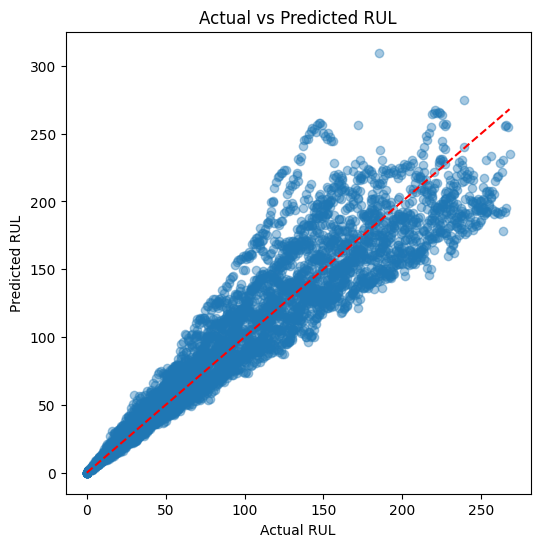

In [31]:
import matplotlib.pyplot as plt

plt.figure(figsize=(6,6))
plt.scatter(y_val, y_pred, alpha=0.4)
plt.plot([0, y_val.max()], [0, y_val.max()], "r--")
plt.xlabel("Actual RUL")
plt.ylabel("Predicted RUL")
plt.title("Actual vs Predicted RUL")
plt.show()

engine level Rul trend

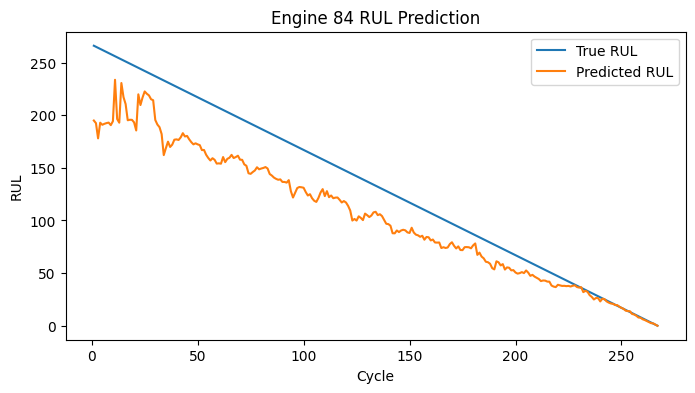

In [32]:
engine_id = val_engines[0]

engine_data = train[train.engine_id == engine_id]
X_engine = X.loc[engine_data.index]

engine_pred = rf.predict(X_engine)

plt.figure(figsize=(8,4))
plt.plot(engine_data["cycle"], engine_data["RUL"], label="True RUL")
plt.plot(engine_data["cycle"], engine_pred, label="Predicted RUL")
plt.xlabel("Cycle")
plt.ylabel("RUL")
plt.title(f"Engine {engine_id} RUL Prediction")
plt.legend()
plt.show()

top influential features

In [33]:
import pandas as pd

feature_importance = pd.Series(
    rf.feature_importances_,
    index=X.columns
).sort_values(ascending=False)

feature_importance.head(15)


cycle_norm             0.821993
sensor_14_roll_mean    0.022461
sensor_9_roll_mean     0.016599
sensor_12_roll_mean    0.013890
sensor_11_roll_mean    0.013037
sensor_7_roll_mean     0.010749
sensor_20_roll_mean    0.007758
sensor_2_roll_mean     0.007468
sensor_4_roll_mean     0.007118
sensor_9_roll_std      0.005477
sensor_21_roll_std     0.005448
sensor_3_roll_std      0.005295
sensor_12_roll_std     0.005186
sensor_21_roll_mean    0.005110
sensor_3_roll_mean     0.004965
dtype: float64

validating data again for gradient boost

In [34]:
print(X_train.shape, y_train.shape)
print(X_val.shape, y_val.shape)

(16561, 49) (16561,)
(4070, 49) (4070,)


training gradient boosting regressor

In [35]:
from sklearn.ensemble import GradientBoostingRegressor

gbr = GradientBoostingRegressor(
    n_estimators=300,
    learning_rate=0.05,
    max_depth=4,
    random_state=42
)

gbr.fit(X_train, y_train)


GradientBoostingRegressor(learning_rate=0.05, max_depth=4, n_estimators=300,
                          random_state=42)

evaluating model performance

In [36]:
y_pred_gbr = gbr.predict(X_val)

mae_gbr = mean_absolute_error(y_val, y_pred_gbr)
rmse_gbr = mean_squared_error(y_val, y_pred_gbr)

print("Gradient Boosting Performance")
print("MAE:", round(mae_gbr, 2))
print("RMSE:", round(rmse_gbr, 2))


Gradient Boosting Performance
MAE: 17.94
RMSE: 649.77


xgboost

In [37]:
from xgboost import XGBRegressor

xgb = XGBRegressor(
    n_estimators=300,
    learning_rate=0.05,
    max_depth=6,
    subsample=0.8,
    colsample_bytree=0.8,
    objective="reg:squarederror",
    random_state=42
)

xgb.fit(X_train, y_train)

y_pred_xgb = xgb.predict(X_val)

mae_xgb = mean_absolute_error(y_val, y_pred_xgb)
rmse_xgb = mean_squared_error(y_val, y_pred_xgb)

print("XGBoost Performance")
print("MAE:", round(mae_xgb, 2))
print("RMSE:", round(rmse_xgb, 2))


XGBoost Performance
MAE: 17.83
RMSE: 646.68


Model comparison

In [51]:
results = pd.DataFrame({
    "Model": ["Random Forest", "Gradient Boosting", "XGBoost"],
    "MAE": [mae, mae_gbr, mae_xgb],
    "RMSE": [rmse, rmse_gbr, rmse_xgb]
})

results



,Model,MAE,RMSE
0,Random Forest,18.185953,652.122622
1,Gradient Boosting,17.942595,649.769294
2,XGBoost,17.832964,646.684491


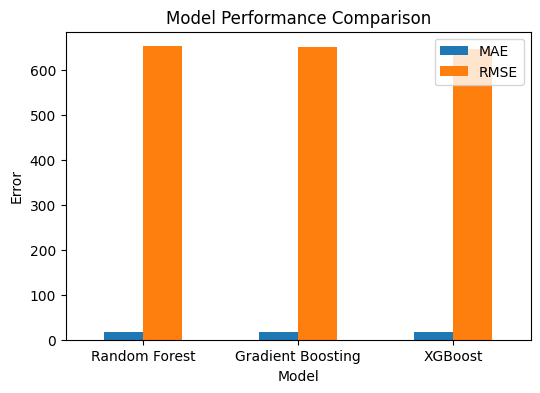

In [52]:
results.set_index("Model").plot(kind="bar", figsize=(6,4))
plt.title("Model Performance Comparison")
plt.ylabel("Error")
plt.xticks(rotation=0)
plt.show()


hyperparameter tunning

In [53]:
from sklearn.model_selection import GridSearchCV

param_grid = {
    "max_depth": [10, 15, 20],
    "n_estimators": [100, 200],
}

grid = GridSearchCV(
    RandomForestRegressor(random_state=42, n_jobs=-1),
    param_grid,
    scoring="neg_mean_absolute_error",
    cv=3
)

grid.fit(X_train, y_train)

print("Best RF params:", grid.best_params_)

Best RF params: {'max_depth': 10, 'n_estimators': 100}


visual comparison on one engine 

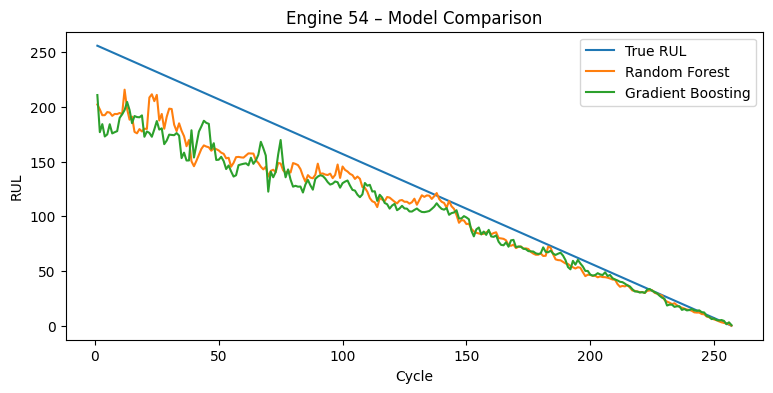

In [40]:
engine_id = val_engines[1]

engine_data = train[train.engine_id == engine_id]
X_engine = X.loc[engine_data.index]

rf_pred = rf.predict(X_engine)
gbr_pred = gbr.predict(X_engine)

plt.figure(figsize=(9,4))
plt.plot(engine_data["cycle"], engine_data["RUL"], label="True RUL")
plt.plot(engine_data["cycle"], rf_pred, label="Random Forest")
plt.plot(engine_data["cycle"], gbr_pred, label="Gradient Boosting")
plt.xlabel("Cycle")
plt.ylabel("RUL")
plt.title(f"Engine {engine_id} – Model Comparison")
plt.legend()
plt.show()


feature importance

In [41]:
gbr_importance = pd.Series(
    gbr.feature_importances_,
    index=X.columns
).sort_values(ascending=False)

gbr_importance.head(10)




cycle_norm             0.903499
sensor_14_roll_mean    0.018121
sensor_9_roll_mean     0.013343
sensor_12_roll_mean    0.009119
sensor_7_roll_mean     0.007861
sensor_11_roll_mean    0.005499
sensor_20_roll_mean    0.004728
sensor_9_roll_std      0.004711
sensor_2_roll_mean     0.004101
sensor_4_roll_mean     0.002487
dtype: float64

load true test RUL

In [42]:
rul_true = pd.read_csv("RUL_FD001.txt", header=None)
rul_true.columns = ["true_RUL"]

print("Number of test engines:", len(rul_true))
rul_true.head()


Number of test engines: 100


,true_RUL
0,112
1,98
2,69
3,82
4,91


In [43]:
test["engine_id"].nunique()


100

prepare test feature matrix

In [44]:
# Drop non-feature columns (same as train)
drop_cols_test = ["engine_id", "run_id", "cycle"]

X_test = test.drop(columns=drop_cols_test)

print("Test feature shape:", X_test.shape)


Test feature shape: (13096, 50)


In [55]:
# Select last cycle of each test engine
test_last = (
    test.sort_values(["engine_id", "cycle"])
        .groupby("engine_id")
        .last()
        .reset_index()
)

# Drop non-feature columns
X_test_last = test_last.drop(columns=["engine_id", "run_id", "cycle"])

print("Test last-cycle shape:", X_test_last.shape)


Test last-cycle shape: (100, 50)


predict RUL for test data

In [58]:
if "RUL_pred" in test.columns:
    test = test.drop(columns=["RUL_pred"])

In [59]:
drop_cols_test = ["engine_id", "run_id", "cycle"]

X_test = test.drop(columns=drop_cols_test)

# safety check
print("Train features:", X.shape[1])
print("Test features :", X_test.shape[1])


Train features: 49
Test features : 49


In [61]:
# Save training feature names (VERY IMPORTANT)
feature_cols = X.columns.tolist()

print("Number of training features:", len(feature_cols))


Number of training features: 49


In [56]:
test["RUL_pred"] = rf.predict(X_test)

test_last = (
    test.groupby("engine_id")
    .last()
    .reset_index()
)

test_last[["engine_id", "RUL_pred"]].head()


,engine_id,RUL_pred
0,1,0.0
1,2,0.0
2,3,0.0
3,4,0.0
4,5,0.0


merge prediction with true RUL

In [48]:
test_results = test_last[["engine_id", "RUL_pred"]].copy()
test_results["true_RUL"] = rul_true["true_RUL"].values

test_results.head()

,engine_id,RUL_pred,true_RUL
0,1,0.0,112
1,2,0.0,98
2,3,0.0,69
3,4,0.0,82
4,5,0.0,91


Evaluation

In [49]:
mae_test = mean_absolute_error(
    test_results["true_RUL"],
    test_results["RUL_pred"]
)

rmse_test = mean_squared_error(
    test_results["true_RUL"],
    test_results["RUL_pred"],
)

print("Final Test Performance (Random Forest)")
print("MAE:", round(mae_test, 2))
print("RMSE:", round(rmse_test, 2))


Final Test Performance (Random Forest)
MAE: 75.52
RMSE: 7430.14


saving final prediction

In [54]:
test_last[["engine_id", "RUL_pred"]].to_csv(
    "FD001_RUL_predictions.csv",
    index=False
)